# Matlab script used to clean data

```
clear;
clc;
dataset = fopen('dataset.txt', 'r');
y_file = fopen('y.txt', 'w');
x_file = fopen('x.txt', 'w');

line = fgetl(dataset);

while ischar(line)
    % converting txt line to array
    splitted = split(line, ';');
    wavelengths = str2double(split(splitted(3), ','));
    reflectance = str2double(split(splitted(2), ','));
    
    % removing dirty channels
    idx = ismember(reflectance, 1.23e34);
    reflectance(idx) = [];
    wavelengths(idx) = [];
    
    % interpolation
    x = linspace(wavelengths(1), wavelengths(end), 2000);
    s = spline(wavelengths, reflectance, x);
    
    % writing result to files
    fprintf(y_file, '%d\n', str2double(splitted(1)));
    fprintf(x_file, '%f ',s);
    fprintf(x_file, '\n');
    
    % getting next line
    line = fgetl(dataset);
end

fclose(dataset);
fclose(y_file);
fclose(x_file);
```

In [ ]:
# connect to GDrive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# import spectral dataset

# read y values (each one a scalar, e.g. the class)
y_file = open("/content/drive/My Drive/dataset/y.txt", "r")
y_str = y_file.readlines()
y_file.close()

# read x values (each one an array of 2000 elements) --> reflectance interpolated with cubic spline
x_file = open("/content/drive/My Drive/dataset/x.txt", "r")
x_str = x_file.readlines()
x_file.close()

labels_map = {
    0: "artifical material",
    1: "coating",
    2: "liquid",
    3: "mineral",
    4: "organic compound",
    5: "soil and texture",
    6: "vegetation"
}

In [ ]:
import numpy as np

y = np.array(y_str).astype(np.float)
x = np.zeros((len(x_str), 2000))
i = 0
for line in x_str:
  x[i] = np.array(line.split()).astype(np.float)
  i = i + 1

In [ ]:
# split dataset into train and test
import sklearn.model_selection

x_train, x_test_tmp, y_train, y_test_tmp = sklearn.model_selection.train_test_split(x, y, test_size=0.3)
x_val, x_test, y_val, y_test = sklearn.model_selection.train_test_split(x_test_tmp, y_test_tmp, test_size=0.5)
#x_train_small, x_test_small, y_train_small, y_test_small = sklearn.model_selection.train_test_split(x_test, y_test, test_size=0.15)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from tqdm.notebook import tqdm

# Setting the device
if torch.cuda.is_available():
    print('GPU enabled!')
    device = torch.device("cuda:0")
else:
    print('You are not using the GPU, activate it following:')
    print('"Runtime" --> "Change runtime type" --> "Hardware accelerator" --> "GPU" --> "Save"')
    device = torch.device("cpu")

# Plot setting
plt.style.use('dark_background')

GPU enabled!


In [ ]:
def accuracy(preds, labels):
    """
    Args:
        preds: torch tensors of shape [batch_size, num_classes]
        labels: torch tensors of shape [batch_size]
    """
    _, preds = torch.max(preds, -1)
    acc = torch.where(labels == preds, torch.ones_like(preds), torch.zeros_like(preds)).sum() / preds.shape[0]
    return acc

In [ ]:
##################################################
# Model
##################################################

# dropout_rate: è un metodo per limitare overfitting nel training set
#               va a selezionare con una certa probabilità ciascun neurone e lo elimina dalla rete
# layer_size è un array che indica il numero di neuroni per ogni hidden + output layer
# in questo caso l'ultimo valore deve essere 7 perché abbiamo 7 classi
class MLP(nn.Module):
    def __init__(self, in_dim, layers_size=[len(labels_map)], activation='sigmoid', lr=8e-1, 
                 init_kind='zeros', dropout_rate=0.0):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.lr = lr
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = self._get_activation(activation)
        self.layers = self._get_layers(layers_size)
        self._init_weights_and_biases(init_kind)
        self._compile()

    def _get_layers(self, layers_size):
        layers = []
        in_dim = self.in_dim
        for idx_l, l_size in enumerate(layers_size):
            layers += [nn.Linear(in_dim, l_size)]
            if idx_l < len(layers_size) - 1:
                layers += [self.activation]
                layers += [self.dropout]
            in_dim = l_size
        return nn.Sequential(*layers)

    # tipi di funzioni di attivazione disponibili
    def _get_activation(self, act_kind):
        if act_kind == 'relu':
            return nn.ReLU()
        elif (act_kind is None) or (act_kind == 'linear'):
            return nn.Identity()
        elif act_kind == 'sigmoid':
            return nn.Sigmoid()
        elif act_kind == 'tanh':
            return nn.Tanh()
        else:
            raise Exception(f'Error. Activation "{act_kind}" is not supported.')

    def _compile(self, lr=1e-3): # definisce loss function e optimizer
                                 # qui usiamo variante Adam di gradient descent, assicura convergenza più veloce
        self.loss = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def _init_weights_and_biases(self, init_kind):
        for l in self.layers:
            if not (type(l) == nn.Linear):
                continue
            if init_kind == 'zeros':
                torch.nn.init.zeros_(l.weight)
            elif init_kind == 'uniform':
                torch.nn.init.uniform_(l.weight, a=-0.1, b=0.1)
            elif init_kind == 'normal': # distribuzione normale standard
                torch.nn.init.normal_(l.weight, mean=0.0, std=1e-3)
            elif init_kind == 'xavier':
                torch.nn.init.xavier_uniform_(l.weight)
            l.bias.data.fill_(0.00) # i bias sono tutti a 0 di default, vengono poi appresi automaticamente

    def forward(self, x): # definisce il passo di forward
        x = self.layers(x)
        return x

    # pytorch calcola automaticamente tutti i gradienti per fare backward in automatico, non serve definire funzione

In [ ]:
##################################################
# Training and evaluation
##################################################
import time

def train(model, dl_train, dl_test, accuracy_fn, device, epochs=10):
    """
    Training function.
    Args:
        model: torch model.
        dl_train: torch dataloader for train. More info at: https://pytorch.org/docs/stable/data.html
        dl_test: torch dataloader for test. More info at: https://pytorch.org/docs/stable/data.html
        accuracy_fn: function used for computing the accuracy.
        device: gpu or cpu.
        epochs: number of epochs for the training.
    """
    def _forward(dl, mode):
        """
        Forward pass of the entire dataset into the model.
        Args:
            dl: torch dataloader. More info at: https://pytorch.org/docs/stable/data.html
            mode: string in ['train', 'test'].
        """
        if mode == 'train':
            model.train()
        else:
            model.eval()

        # Cache
        running_loss, running_acc = [], []
        pbar = tqdm(desc='Training' if mode == 'train' else 'Test', 
                    total=len(dl.dataset))
        
        # Loop over the dataset
        for x, y in dl:

            # CPU -> GPU
            x = x.to(device)
            y = y.to(device)
            batch_size = x.shape[0]

            # azzeriamo i gradienti per cancellare il passo precedente
            if mode == 'train':
                model.optimizer.zero_grad()

            # Image to vector: [batch_size, 32, 32, 3] -> [batch_size, 3072]
            # x = x.view(batch_size, -1)

            # Forward + backward + optimize
            logits = model(x)
            loss_batch = model.loss(logits, y)
            acc = accuracy_fn(F.softmax(logits, -1), y)
            if mode == 'train':
                loss_batch.backward()
                model.optimizer.step()

            # Cache
            running_loss += [loss_batch.item()]
            running_acc += [acc.item()]
            pbar.update(batch_size)
            pbar.set_postfix({'loss': running_loss[-1], 'acc': running_acc[-1]})
        pbar.set_postfix({'loss': np.mean(running_loss), 'acc': np.mean(running_acc)})
        pbar.close()
        return np.mean(running_loss), np.mean(running_acc)
        
    # Start timer
    t0 = time.time()

    # Caching useful quantities
    loss = {'train': [], 'test': []}
    accuracy = {'train': [], 'test': []}
    dls = {'train': dl_train, 'test': dl_test}

    # Loop over the epochs
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1:03d}/{epochs:03d}')
        
        for mode in ['train', 'test']:
            dl = dls[mode]
            loss_epoch, acc_epoch = _forward(dl, mode)
            loss[mode] += [loss_epoch]
            accuracy[mode] += [acc_epoch]

    # Stop timer
    t1 = time.time()
    duration = t1 - t0
    return loss, accuracy, duration

In [ ]:
# preparing dataset to be used with pytorch
import torch.utils.data as data_utils

x_train_tf = torch.from_numpy(x_train).float()
y_train_tf = torch.from_numpy(y_train).long()
x_test_tf = torch.from_numpy(x_test).float()
y_test_tf = torch.from_numpy(y_test).long()

######### BATCH SIZE #############
batch_size = 10     ########## NB
##################################

ds_train = data_utils.TensorDataset(x_train_tf, y_train_tf)
dl_train = data_utils.DataLoader(ds_train, batch_size=batch_size, shuffle=True)

ds_test = data_utils.TensorDataset(x_test_tf, y_test_tf)
dl_test = data_utils.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

in_dim = np.prod(ds_train.__getitem__(0)[0].shape)

# Dataset info
print('##################################################')
print('# Dataset Info')
print('##################################################')
print()
print('Name: usgs_splib07')
print('Num Train Samples:', len(ds_train))
print('Num Test Samples:', len(ds_test))
print('Number of classes:', len(labels_map))
print('Classes:')
for i in labels_map:
  print(i, ": ", labels_map[i])

##################################################
# Dataset Info
##################################################

Name: usgs_splib07
Num Train Samples: 43017
Num Test Samples: 9218
Number of classes: 7
Classes:
0 :  artifical material
1 :  coating
2 :  liquid
3 :  mineral
4 :  organic compound
5 :  soil and texture
6 :  vegetation


In [ ]:
def get_hyper_params():
    """
    Define here the parameters of the architecture of the model, such as the
    layers_size, the activation. Define also the parameters related to the 
    training like the learning rate, the nuber of epochs, the initialization
    for the weights and the dropout rate.
    """
    ###############################################
    # EDIT THESE PARAMETERS TO MODIFY THE NETWORK #
    ###############################################

    hyper_params = {
        'layers_size': [2000, 1500, 500, len(labels_map)],
        'activation': 'relu',
        'lr': 0.0001,
        'epochs': 60,
        'init_kind': 'xavier',
        'dropout_rate': 0.2
    }
    return hyper_params

# Create the model
hyper_params = get_hyper_params()
model = MLP(
    in_dim=in_dim,
    layers_size=hyper_params['layers_size'],
    activation=hyper_params['activation'],
    lr=hyper_params['lr'],
    init_kind=hyper_params['init_kind'],
    dropout_rate=hyper_params['dropout_rate'],
).to(device)

# See model architecture
print(model)

MLP(
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=2000, out_features=2000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=2000, out_features=1500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=500, out_features=7, bias=True)
  )
  (loss): CrossEntropyLoss()
)


In [ ]:
# train the model
loss, acc, time_training = train(model, dl_train, dl_test, accuracy, device=device, epochs=hyper_params['epochs'])
print(f'Network trained in {time_training:.2f} [sec]')

Epoch 001/060



Epoch 002/060



Epoch 003/060



Epoch 004/060



Epoch 005/060



Epoch 006/060



Epoch 007/060



Epoch 008/060



Epoch 009/060



Epoch 010/060



Epoch 011/060



Epoch 012/060



Epoch 013/060



Epoch 014/060



Epoch 015/060



Epoch 016/060



Epoch 017/060



Epoch 018/060



Epoch 019/060



Epoch 020/060



Epoch 021/060



Epoch 022/060



Epoch 023/060



Epoch 024/060



Epoch 025/060



Epoch 026/060



Epoch 027/060



Epoch 028/060



Epoch 029/060



Epoch 030/060



Epoch 031/060



Epoch 032/060



Epoch 033/060



Epoch 034/060



Epoch 035/060



Epoch 036/060



Epoch 037/060



Epoch 038/060



Epoch 039/060



Epoch 040/060



Epoch 041/060



Epoch 042/060



Epoch 043/060



Epoch 044/060



Epoch 045/060



Epoch 046/060



Epoch 047/060



Epoch 048/060



Epoch 049/060



Epoch 050/060



Epoch 051/060



Epoch 052/060



Epoch 053/060



Epoch 054/060



Epoch 055/060



Epoch 056/060



Epoch 057/060



Epoch 058/060



Epoch 059/060



Epoch 060/060



Network trained in 2799.90 [sec]


In [ ]:
# save model to file
#import pickle

#model_file = open("/content/drive/My Drive/dataset/neural_network.pkl", "wb")
#pickle.dump(model, model_file)
#model_file.close()

In [ ]:
# validation

total = np.zeros(7)
correct = np.zeros(7)
for i in range(len(y_val)):
  current_x = torch.from_numpy(x[i]).float().to(device)
  current_y = torch.as_tensor(y[i]).long().to(device)
  pred = model(current_x).cpu().detach().numpy()
  class_pred = np.argmax(pred)
  total[int(y[i])] += 1
  if class_pred == y[i]:
    correct[int(y[i])] += 1

percentage = correct/total * 100

print("VALIDATION DATA:")
print("TOTAL ARRAY")
print(total)
print("CORRECT ARRAY")
print(correct)
print("PERCENTAGE ARRAY")
print(percentage)

VALIDATION DATA:
TOTAL ARRAY
[1160.   48.   96. 5104. 1325.  627.  858.]
CORRECT ARRAY
[1129.   48.   96. 5044. 1325.  561.  852.]
PERCENTAGE ARRAY
[ 97.32758621 100.         100.          98.82445141 100.
  89.47368421  99.3006993 ]


In [ ]:
sum = 0
for i in total:
  sum +=i
print(sum)

c = 0
for i in correct:
  c+=i
print(c)

print(c/sum*100)

9218.0
9055.0
98.23172054675635


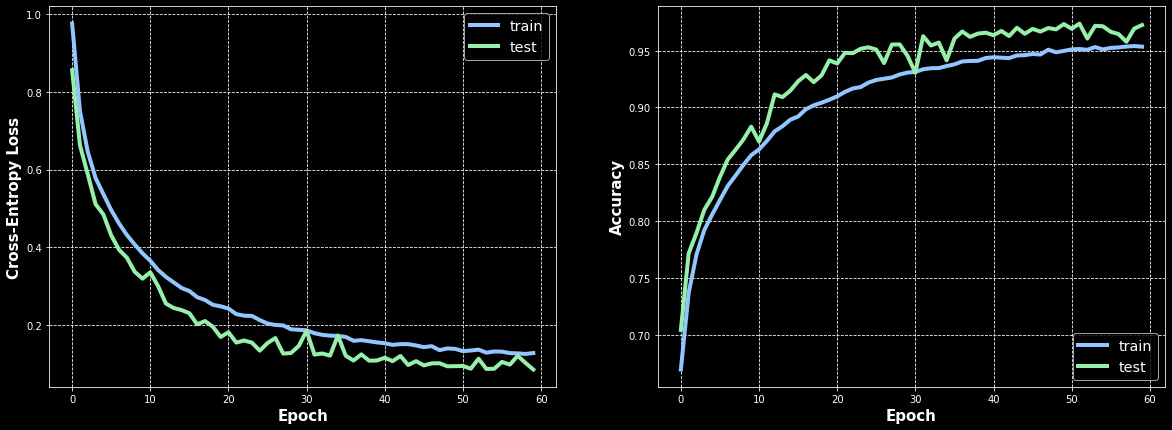

In [ ]:
plt.style.use('seaborn-pastel')
# Plots realted to the training
plt.figure(figsize=(20, 7))

# Plot loss
plt.subplot(1, 2, 1)
for mode in ['train', 'test']:
    plt.plot(loss[mode], lw=4, zorder=5, label=mode)
plt.grid(True, zorder=0, ls='--')
plt.ylabel('Cross-Entropy Loss', fontweight='bold', fontsize=15)
plt.xlabel('Epoch', fontweight='bold', fontsize=15)
plt.legend(fontsize='x-large', loc='upper right')

# Plot accuracy
plt.subplot(1, 2, 2)
for mode in ['train', 'test']:
    plt.plot(acc[mode], lw=4, zorder=5, label=mode)
plt.grid(True, zorder=0, ls='--')
plt.ylabel('Accuracy', fontweight='bold', fontsize=15)
plt.xlabel('Epoch', fontweight='bold', fontsize=15)
plt.legend(fontsize='x-large', loc='lower right')
plt.show()